In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


In [2]:
from explore_tool import load_info,press,pressing,frame_to_delta,replay_to_xy,plot_trace_2d,plot_trace_3d,plot_trace_sequence,summary

In [3]:
info = load_info('replay/RB/th10_ud000c.rpy.json')

In [5]:
summary(info)

th10 Reimu B lunatic all
frame score
8464 2554273
10098 6970839
12246 13421823
14907 24347429
16788 38167049
20566 46866369


# 微移时间段

进行微移的时间反映了危险的时刻，这个信息应该有用。

其特征包括按着shift与不连续的移动。先看看shift的分布情况

In [6]:
replay = info['stages'][0]['replay']

In [8]:
t = np.arange(len(replay))
y = np.array(replay.pressing_shift)

(-0.2, 2)

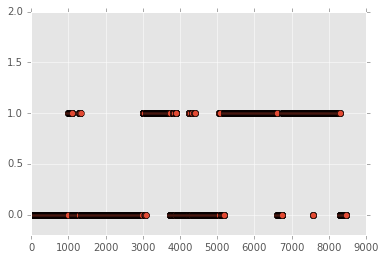

In [9]:
plt.plot(t,y,'o')
plt.ylim(-0.2,2)

(-0.2, 2)

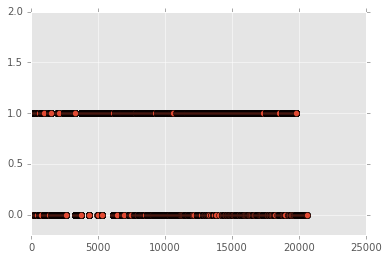

In [12]:
replay = info['stages'][5]['replay']

t = np.arange(len(replay))
y = np.array(replay.pressing_shift)
plt.plot(t,y,'o')
plt.ylim(-0.2,2)

(-0.2, 2)

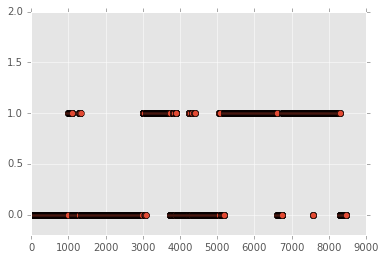

In [13]:
replay = info['stages'][0]['replay']

t = np.arange(len(replay))
y = np.array(replay.pressing_shift)
plt.plot(t,y,'o')
plt.ylim(-0.2,2)

In [18]:
groupby = replay.groupby(replay.index.map(lambda t:t//60))

(-1, 61)

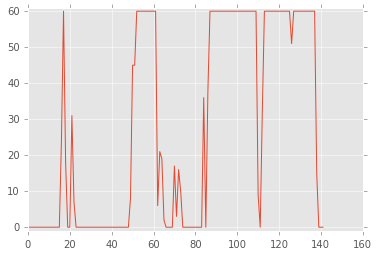

In [23]:
plt.plot(groupby.sum()['pressing_shift'])
plt.ylim(-1,61)

In [52]:
def look_pressing(key, info, press = False):
    for i in range(info['stage']):
        stage = info['stages'][i]
        df = stage['replay']
        groupby = df['{}_{}'.format('press' if press else 'pressing', key)].groupby(df.index.map(lambda t: t//60))
        gs = groupby.sum()
        #gs.plot()
        plt.fill_between(np.arange(len(gs)),gs)
        plt.ylim(-1,61)
        plt.title('stage {}'.format(i+1))
        #plt.legend()
        plt.show()
        
def look_pressing_shift(info):
    look_pressing('shift', info)

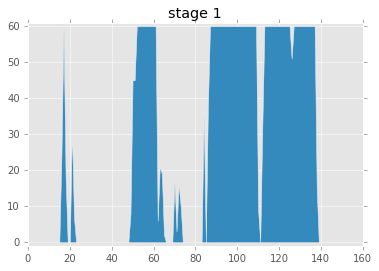

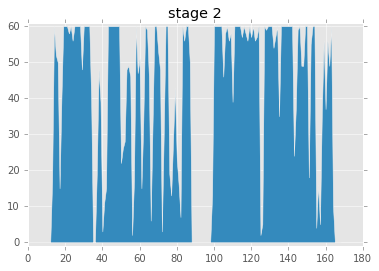

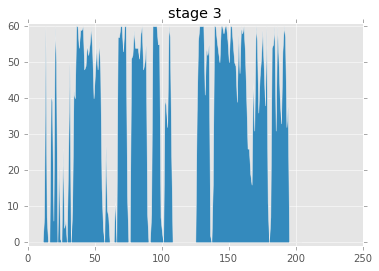

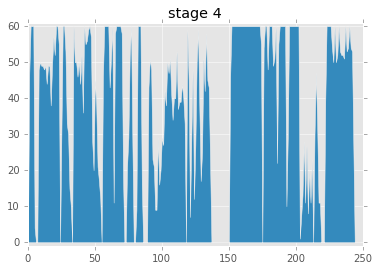

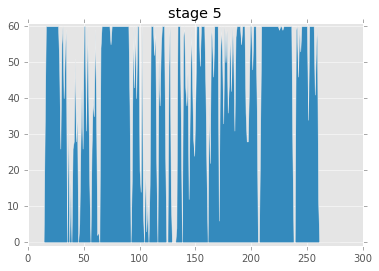

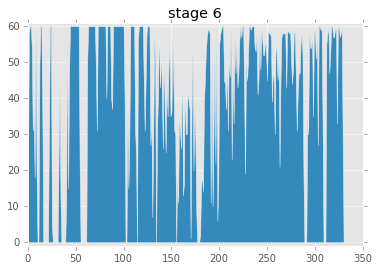

In [53]:
look_pressing_shift(info)

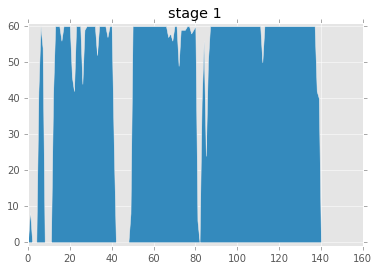

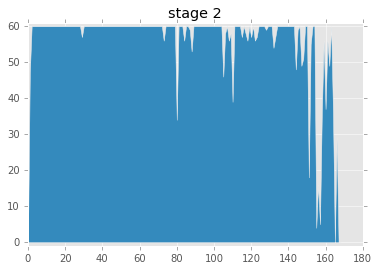

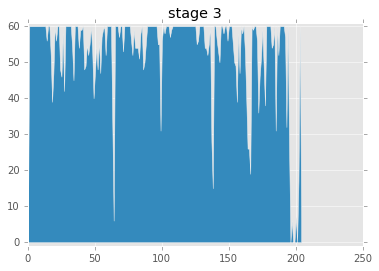

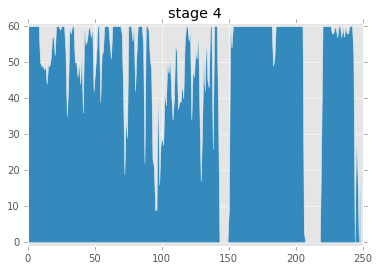

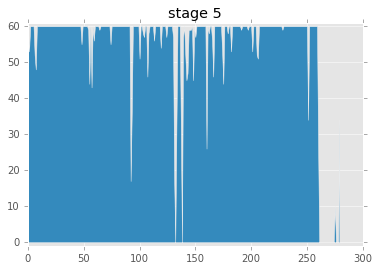

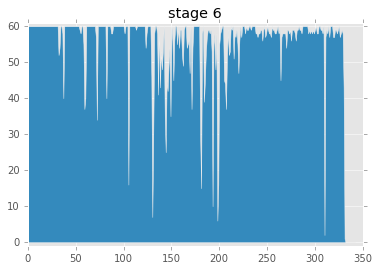

In [54]:
look_pressing('z',info)

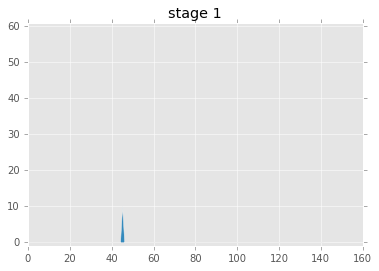

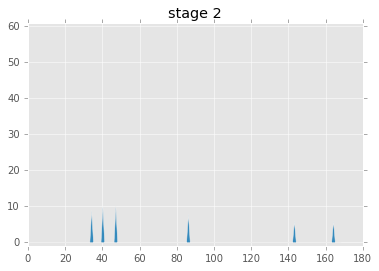

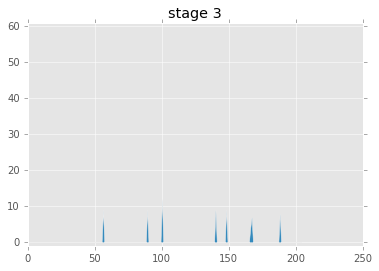

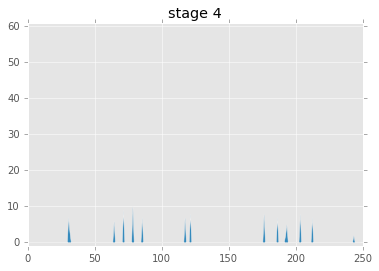

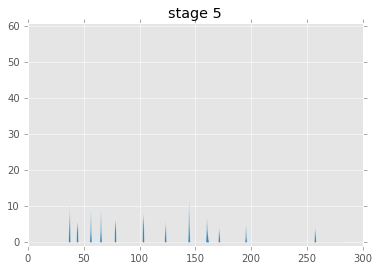

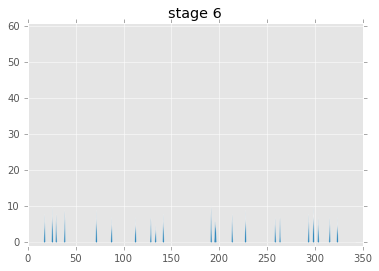

In [55]:
look_pressing('x',info)

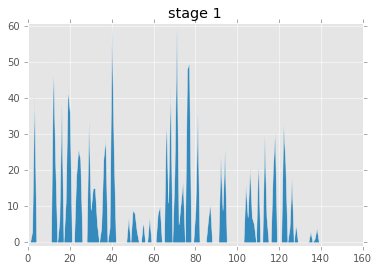

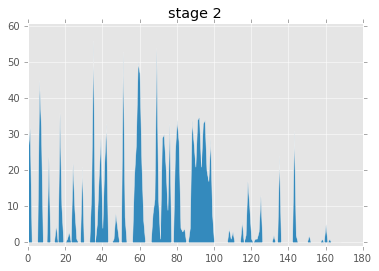

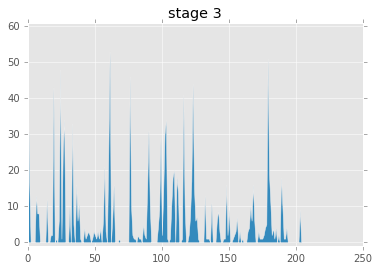

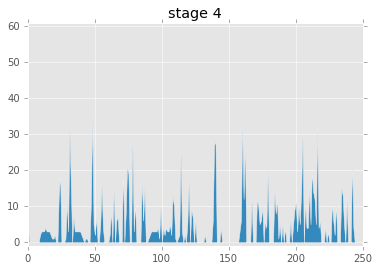

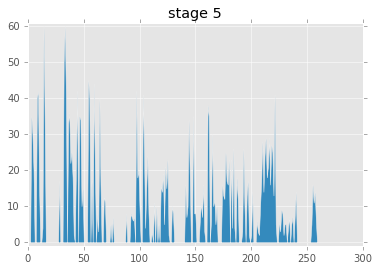

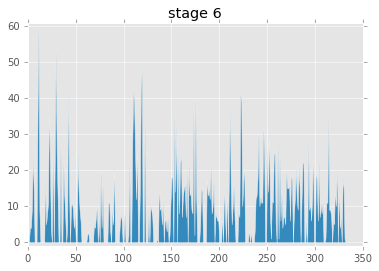

In [57]:
look_pressing('left',info)

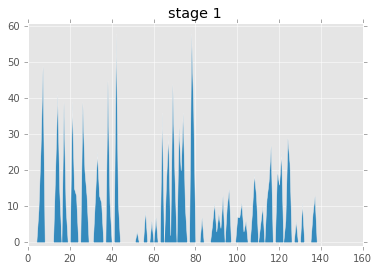

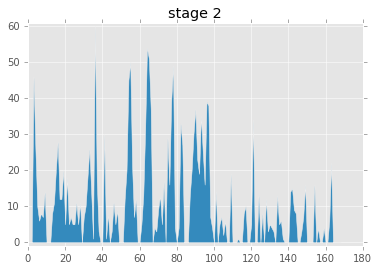

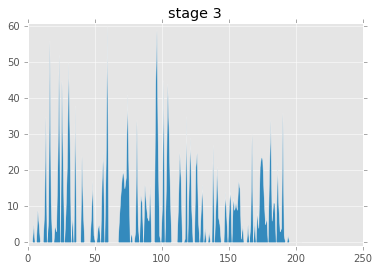

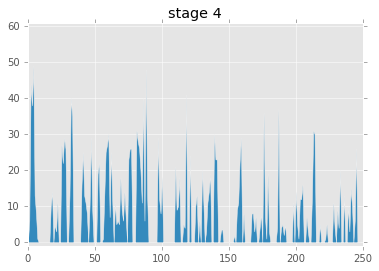

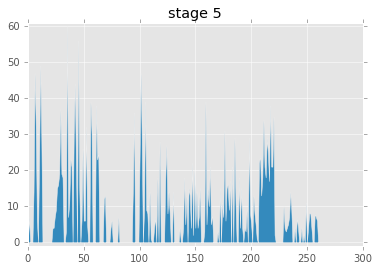

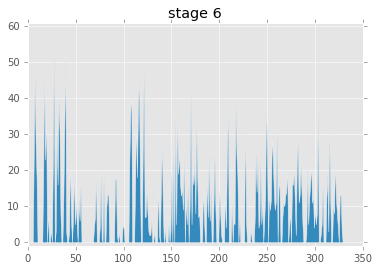

In [58]:
look_pressing('right',info)

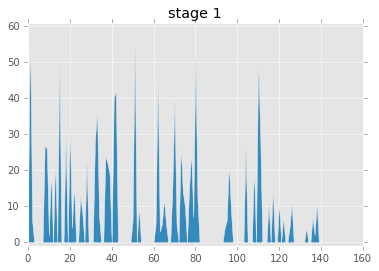

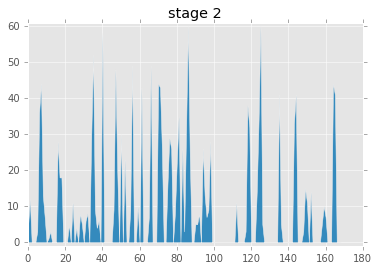

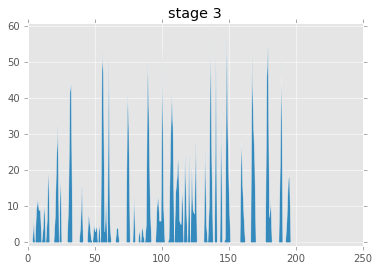

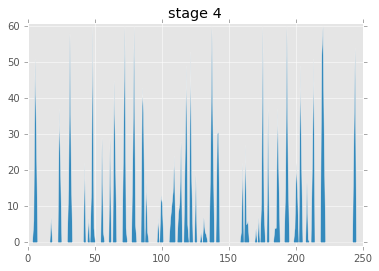

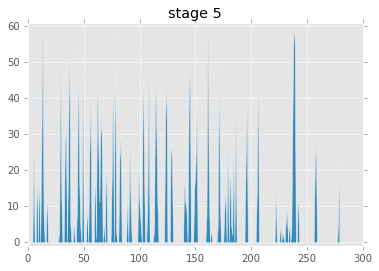

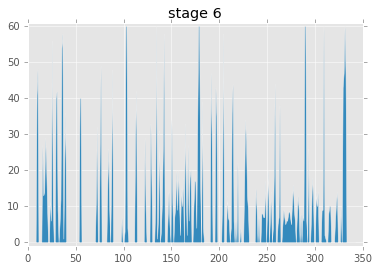

In [59]:
look_pressing('up',info)

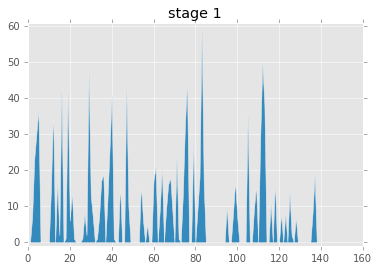

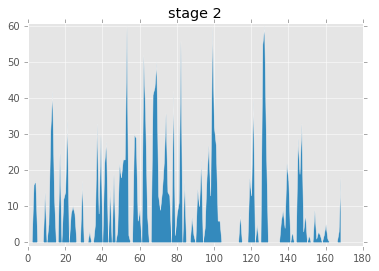

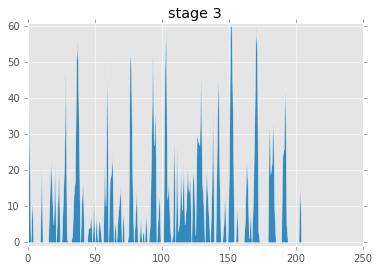

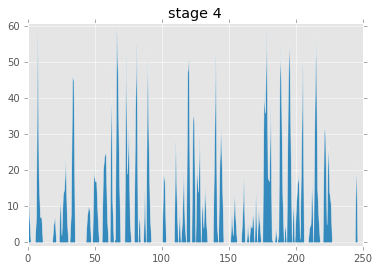

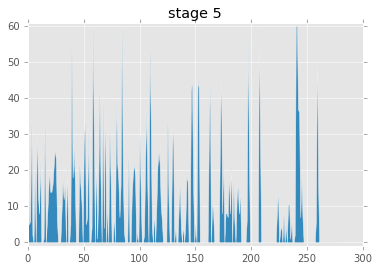

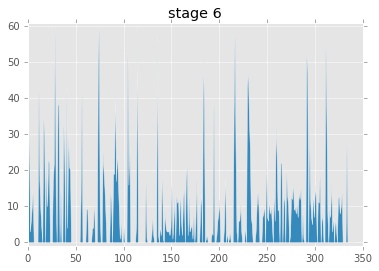

In [60]:
look_pressing('down',info)

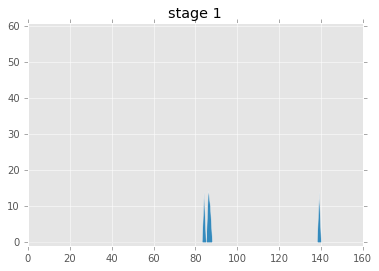

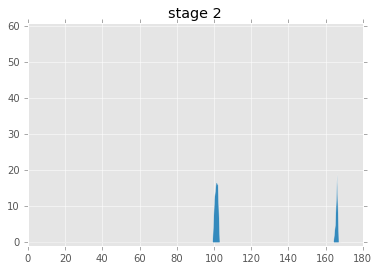

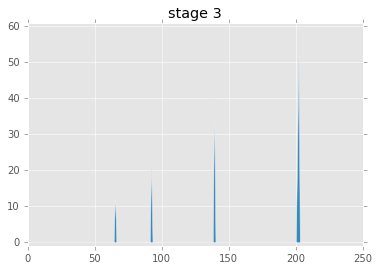

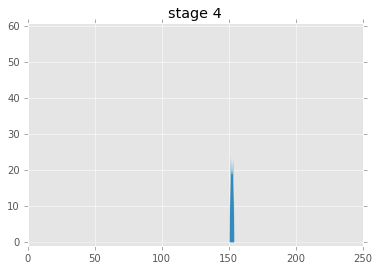

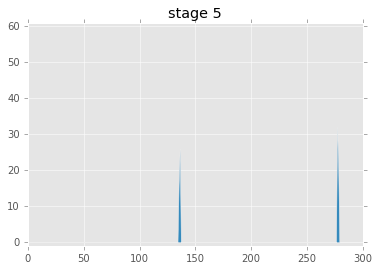

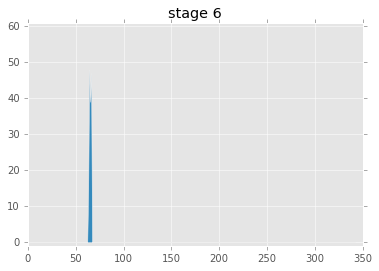

In [61]:
look_pressing('ctrl',info)

方向键按键时间单独来看看不出什么，而合起来看，如以位置观点看的话上一个notebook尝试过，因为一些不明机制和无法获知死亡时间原因等
看起来行不通。看来还原到位置模型的方式失败了。

除了方向键外，shift,z,x中x只有单点峰，这是因为x的无敌时间超过一秒，有理性的人不会按超过一次。另外按x的时间可以决定场面的难度，
可能可以辅助我们进行情景对齐。

z值看起来意思不大，基本一直在突突突。不过没有突突突的时间通常也是有特殊意义的，可以辅助分段。ctrl基本是分割阶段的绝对信息了，
虽然可能有噪声（弹幕游戏你还动辄按错还是另请高明吧）。shift最为复杂，好像有点意思。




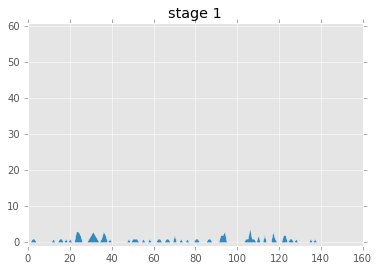

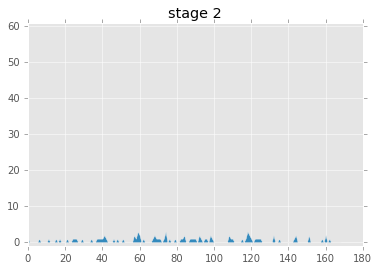

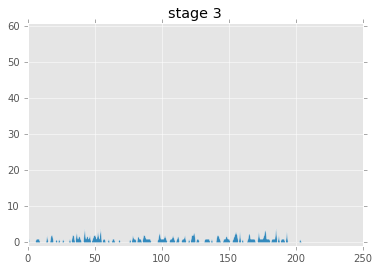

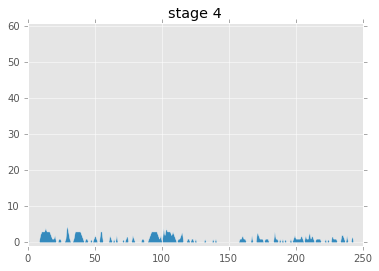

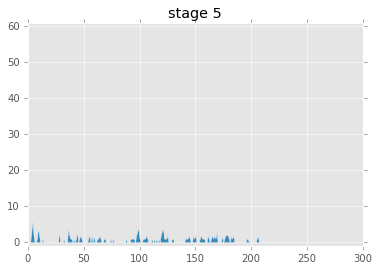

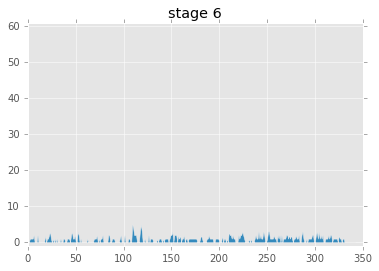

In [62]:
look_pressing('left',info,press=True)

# 人工指数

首先我们感兴趣的是真正的活动范围，我们计算60frame，即一秒内的真正的移动距离。

In [97]:
def info_wrap(func = None, use_index = None):
    # ugly trick
    
    def _func(info, inplace = True):
        for i in range(info['stage']):
            stage = info['stages'][i]
            if use_index:
                res = func(i,stage['replay'])
            else:
                res = func(stage['replay'])
            if not inplace:
                stage['replay'] = res
    
    if use_index == None:
        use_index = False
        return _func
    else:
        assert func == None
        assert use_index in {True,False}
        def __func(___func):
            nonlocal func
            func = ___func
            return _func
        return __func

@info_wrap
def delta_equip(df):
    df['speed'] = df['pressing_shift'] * 2.0 + (1-df['pressing_shift'])*4.5
    df['dx'] = (-df['pressing_left'] + df['pressing_right'])*df['speed']
    df['dy'] = (-df['pressing_down'] + df['pressing_up'])*df['speed']
    df['move'] = np.abs(df['dx']) + np.abs(df['dy'])



In [75]:
delta_equip(info)

In [76]:
df = info['stages'][0]['replay']

In [79]:
df2 = df.groupby(df.index.map(lambda t:t//60)).sum()

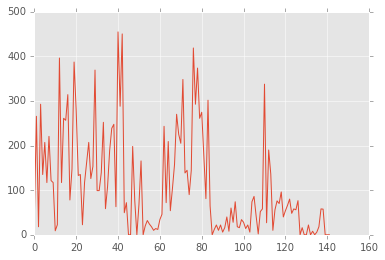

In [80]:
plt.plot(np.abs(df2['dx'])+np.abs(df2['dy']))

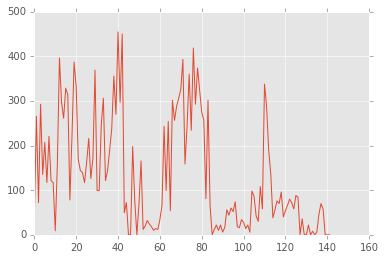

In [81]:
plt.plot(df2['move'])

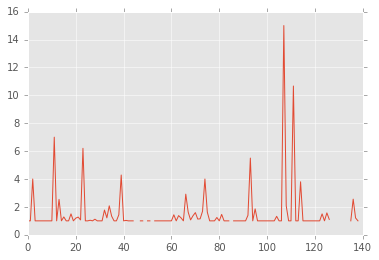

In [86]:
plt.plot(df2['move']/(np.abs(df2['dx'])+np.abs(df2['dy'])))

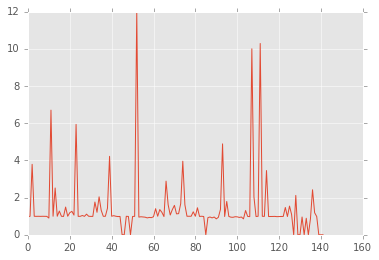

In [87]:
plt.plot(df2['move']/(np.abs(df2['dx'])+np.abs(df2['dy'])+1))

In [103]:
@info_wrap(use_index = True)
def show_move_situation(i,df):
    df2 = df.groupby(df.index.map(lambda t:t//60)).sum()
    plt.plot(np.abs(df2['dx'])+np.abs(df2['dy']))
    plt.title('stage {} abs movment'.format(i+1))
    plt.show()
    plt.plot(df2['move']/(np.abs(df2['dx'])+np.abs(df2['dy'])+1))
    plt.title('stage {} micro movment index (with +1 smooth)'.format(i+1))
    plt.show()


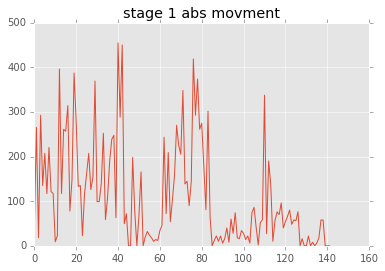

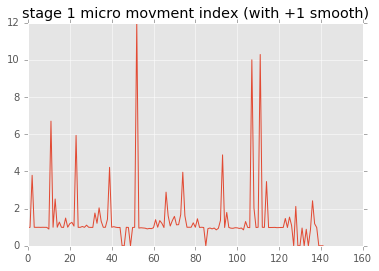

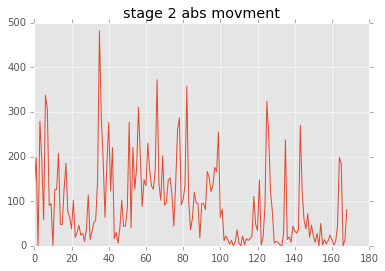

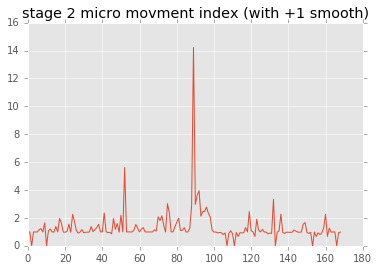

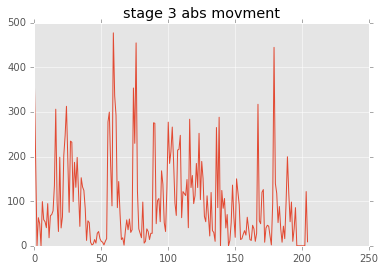

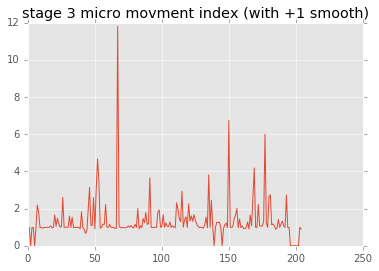

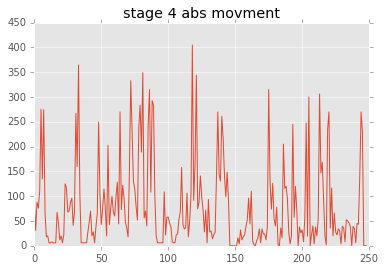

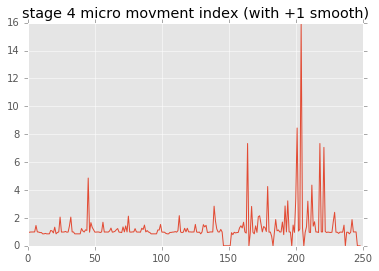

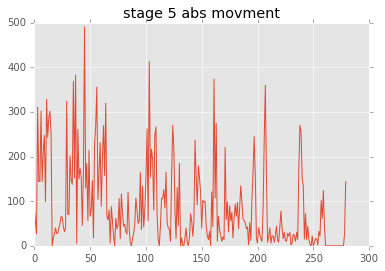

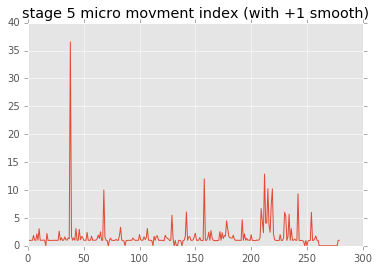

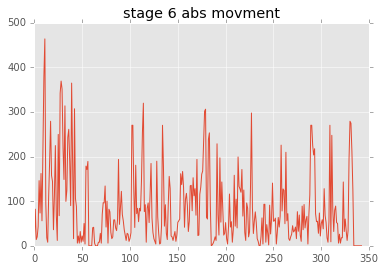

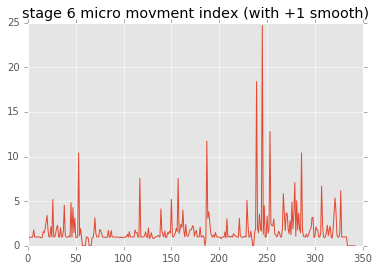

In [104]:
show_move_situation(info)

虽然看上去有些意思，但并不能马上看出什么（值得建模的东西）。。